In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import xgboost
import lightgbm
import warnings
# from eli5.sklearn import PermutationImportance # **
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
warnings.filterwarnings('ignore')

In [50]:
df = pd.read_csv('/Users/hj/Documents/무제/주조공정/casting.csv', encoding='cp949', index_col=0)
df.head()

,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,facility_operation_cycleTime,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:06,258,가동,ON,731.0,119,...,1449.0,550.0,700.0,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN
1,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:08,243,가동,ON,720.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:08,0.0,NaN,8412,B
2,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:58,244,가동,ON,721.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:58,0.0,NaN,8412,B
3,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:48:03,245,가동,ON,721.0,100,...,NaN,483.0,0.0,30.0,25,2019-01-02 16:48:03,0.0,NaN,8412,B
4,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:50:08,246,가동,ON,721.0,99,...,NaN,486.0,0.0,30.0,25,2019-01-02 16:50:08,0.0,NaN,8412,B


In [51]:
pass_count = len(df[df['passorfail']==0])
fail_count = len(df[df['passorfail']==1])

print("양품 개수:", pass_count)
print("불량 개수:", fail_count)
print("불량품: ", fail_count/(fail_count + pass_count) * 100)

양품 개수: 87998
불량 개수: 4016
불량품:  4.364553220162149


In [52]:
use_col = df.dtypes[df.dtypes!='object'].index
df = df[use_col]
df

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,molten_volume,cast_pressure,biscuit_thickness,upper_mold_temp1,...,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,258,731.0,119,120,110.0,112.0,75.0,331.0,35.0,198.0,...,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,0.0,8722
1,243,720.0,98,125,109.0,109.0,NaN,309.0,48.0,250.0,...,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
2,244,721.0,98,122,109.0,109.0,NaN,309.0,48.0,250.0,...,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
3,245,721.0,100,125,112.0,109.0,NaN,308.0,49.0,268.0,...,NaN,211.0,179.0,NaN,483.0,0.0,30.0,25,0.0,8412
4,246,721.0,99,123,109.0,110.0,NaN,309.0,49.0,276.0,...,NaN,216.0,187.0,NaN,486.0,0.0,30.0,25,0.0,8412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,71,731.0,122,122,100.0,101.0,NaN,331.0,49.0,83.0,...,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
92011,72,731.0,120,121,100.0,101.0,NaN,331.0,54.0,83.0,...,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
92012,73,732.0,122,135,100.0,101.0,NaN,331.0,52.0,79.0,...,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
92013,74,732.0,133,122,100.0,101.0,NaN,331.0,53.0,82.0,...,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


In [53]:
df_copy = df.copy()
df_copy

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,molten_volume,cast_pressure,biscuit_thickness,upper_mold_temp1,...,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,258,731.0,119,120,110.0,112.0,75.0,331.0,35.0,198.0,...,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,0.0,8722
1,243,720.0,98,125,109.0,109.0,NaN,309.0,48.0,250.0,...,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
2,244,721.0,98,122,109.0,109.0,NaN,309.0,48.0,250.0,...,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
3,245,721.0,100,125,112.0,109.0,NaN,308.0,49.0,268.0,...,NaN,211.0,179.0,NaN,483.0,0.0,30.0,25,0.0,8412
4,246,721.0,99,123,109.0,110.0,NaN,309.0,49.0,276.0,...,NaN,216.0,187.0,NaN,486.0,0.0,30.0,25,0.0,8412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,71,731.0,122,122,100.0,101.0,NaN,331.0,49.0,83.0,...,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
92011,72,731.0,120,121,100.0,101.0,NaN,331.0,54.0,83.0,...,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
92012,73,732.0,122,135,100.0,101.0,NaN,331.0,52.0,79.0,...,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
92013,74,732.0,133,122,100.0,101.0,NaN,331.0,53.0,82.0,...,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


In [54]:
df_copy.columns

Index(['count', 'molten_temp', 'facility_operation_cycleTime',
       'production_cycletime', 'low_section_speed', 'high_section_speed',
       'molten_volume', 'cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
       'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
       'sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'EMS_operation_time', 'passorfail', 'mold_code'],
      dtype='object')

In [55]:
df_copy.shape

(92015, 21)

In [56]:
df_copy.isnull().sum()

count                               0
molten_temp                      2261
facility_operation_cycleTime        0
production_cycletime                0
low_section_speed                   1
high_section_speed                  1
molten_volume                   45130
cast_pressure                       1
biscuit_thickness                   1
upper_mold_temp1                    1
upper_mold_temp2                    1
upper_mold_temp3                  313
lower_mold_temp1                    1
lower_mold_temp2                    1
lower_mold_temp3                  313
sleeve_temperature                  1
physical_strength                   1
Coolant_temperature                 1
EMS_operation_time                  0
passorfail                          1
mold_code                           0
dtype: int64

In [57]:
df_copy.describe().T
# 변수의 개수가 많아 한눈에 확인하기 어려울땐 .T(transfose)를 이용해 행,열을 바꾸는 전치행렬 실행

,count,mean,std,min,25%,50%,75%,max
count,92015.0,148.510895,87.969953,1.0,72.0,146.0,222.0,334.0
molten_temp,89754.0,718.618513,51.728659,0.0,713.0,728.0,730.0,735.0
facility_operation_cycleTime,92015.0,121.555007,12.116145,0.0,117.0,119.0,122.0,457.0
production_cycletime,92015.0,122.514525,13.595314,0.0,119.0,121.0,123.0,485.0
low_section_speed,92014.0,110.794999,305.181962,0.0,110.0,110.0,110.0,65535.0
high_section_speed,92014.0,112.624959,10.759272,0.0,112.0,112.0,112.0,388.0
molten_volume,46885.0,154.976624,485.640901,0.0,49.0,67.0,85.0,2767.0
cast_pressure,92014.0,324.554535,27.327683,41.0,329.0,330.0,331.0,348.0
biscuit_thickness,92014.0,50.666486,17.925620,0.0,47.0,50.0,53.0,422.0
upper_mold_temp1,92014.0,186.208870,46.041322,18.0,163.0,194.0,222.0,1449.0


In [58]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92015 entries, 0 to 92014
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   count                         92015 non-null  int64  
 1   molten_temp                   89754 non-null  float64
 2   facility_operation_cycleTime  92015 non-null  int64  
 3   production_cycletime          92015 non-null  int64  
 4   low_section_speed             92014 non-null  float64
 5   high_section_speed            92014 non-null  float64
 6   molten_volume                 46885 non-null  float64
 7   cast_pressure                 92014 non-null  float64
 8   biscuit_thickness             92014 non-null  float64
 9   upper_mold_temp1              92014 non-null  float64
 10  upper_mold_temp2              92014 non-null  float64
 11  upper_mold_temp3              91702 non-null  float64
 12  lower_mold_temp1              92014 non-null  float64
 13  lower_

In [59]:
df_copy.drop('molten_volume', axis=1, inplace=True)  # 전체의 50%가 결측인 molten_volume 칼럼 제거 
df_copy.dropna(axis=0, inplace=True) # 칼럼 별 결측있는 행 제거 
df_copy.reset_index(drop=True, inplace=True) # dropna로 인한 인덱스 꼬임 방지를 위해 reset_index()로 인덱스번호 초기화
df_copy

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,258,731.0,119,120,110.0,112.0,331.0,35.0,198.0,116.0,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,0.0,8722
1,73,731.0,119,120,109.0,125.0,177.0,48.0,24.0,33.0,1449.0,30.0,273.0,1449.0,479.0,708.0,35.0,23,1.0,8722
2,1,731.0,119,123,109.0,112.0,176.0,49.0,26.0,55.0,1449.0,30.0,323.0,1449.0,513.0,700.0,35.0,23,1.0,8722
3,2,731.0,119,124,109.0,112.0,331.0,47.0,31.0,65.0,1449.0,30.0,343.0,1449.0,531.0,708.0,34.0,23,1.0,8722
4,3,731.0,120,124,110.0,112.0,331.0,46.0,36.0,73.0,1449.0,31.0,343.0,1449.0,544.0,707.0,34.0,23,1.0,8722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89436,71,731.0,122,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
89437,72,731.0,120,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
89438,73,732.0,122,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
89439,74,732.0,133,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


In [60]:
# 변수들에 존재하는 이상치를 상하한 0.1% 에 해당하는 값으로 제거함

for col in df_copy.dtypes[df_copy.dtypes!='object'].index:
    UCL = np.percentile(df_copy[col], 99.9)
    LCL = np.percentile(df_copy[col], 0.1)
    df_copy = df_copy[(df_copy[col] <= UCL) & (df_copy[col] >= LCL)]

df_copy.reset_index(drop=True, inplace=True)
df_copy

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,32,729.0,127,128,109.0,112.0,330.0,45.0,142.0,74.0,1449.0,162.0,206.0,1449.0,515.0,707.0,36.0,23,0.0,8722
1,2,729.0,126,82,110.0,112.0,158.0,53.0,168.0,116.0,101.0,127.0,128.0,1449.0,515.0,715.0,24.0,23,1.0,8573
2,3,730.0,126,129,110.0,112.0,185.0,56.0,194.0,133.0,106.0,148.0,146.0,1449.0,529.0,705.0,25.0,23,1.0,8573
3,4,731.0,126,84,110.0,112.0,191.0,56.0,212.0,146.0,113.0,163.0,159.0,1449.0,530.0,715.0,26.0,23,1.0,8573
4,5,731.0,126,87,110.0,112.0,189.0,57.0,216.0,153.0,119.0,171.0,167.0,1449.0,528.0,713.0,26.0,23,1.0,8573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87254,71,731.0,122,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
87255,72,731.0,120,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
87256,73,732.0,122,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
87257,74,732.0,133,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


In [61]:
# 양품집단과 불량 집단간 T-test
# '양품 집단과 불량 집단의 평균 차이가 없다'를 귀무 가설
# '양품 집단과 불량집단의 평균에는 차이가 있다'를 대립 가설로 설정
t_test = []
for i, col in enumerate(df_copy.columns):
    t=scipy.stats.ttest_ind(df_copy[df_copy['passorfail']==1][col], df_copy[df_copy['passorfail']==0][col], equal_var=False)
    t_test.append([col, t[0], t[1]])

df_ttest = pd.DataFrame(t_test, columns=['col', 'tvalue', 'pvalue'])

use_t_list = []
for i in range(len(df_ttest)):
    if df_ttest['pvalue'][i] < 0.1:
        use_t_list.append(df_ttest['col'][i])

df_ttest

# p-value값이 0.1 미만인 경우 귀무가설을 기각하고 대립가설 채택함. 
# 즉 해당 변수는 양품집단과 불량집단 간 유의미한 차이를 보이는 변수이므로, 모델 학습에 사용
# 'facility_operation_cycleTime' 변수가 0.1을 초과해 귀무가설을 채택하여 제외, 제거됨

,col,tvalue,pvalue
0,count,-45.044308,0.000000e+00
1,molten_temp,3.786891,1.552251e-04
2,facility_operation_cycleTime,0.830063,4.065656e-01
3,production_cycletime,-16.718089,3.974998e-60
4,low_section_speed,-17.048564,2.804018e-62
5,high_section_speed,7.086440,1.706243e-12
6,cast_pressure,-63.993068,0.000000e+00
7,biscuit_thickness,3.641038,2.761401e-04
8,upper_mold_temp1,-48.991533,0.000000e+00
9,upper_mold_temp2,-51.139842,0.000000e+00


In [62]:
df_copy = df_copy[use_t_list]
df_copy

# 유의미한 차이를 보이는 변수들로 데이터프레임 재구성

,count,molten_temp,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,32,729.0,128,109.0,112.0,330.0,45.0,142.0,74.0,1449.0,162.0,206.0,1449.0,515.0,707.0,36.0,23,0.0,8722
1,2,729.0,82,110.0,112.0,158.0,53.0,168.0,116.0,101.0,127.0,128.0,1449.0,515.0,715.0,24.0,23,1.0,8573
2,3,730.0,129,110.0,112.0,185.0,56.0,194.0,133.0,106.0,148.0,146.0,1449.0,529.0,705.0,25.0,23,1.0,8573
3,4,731.0,84,110.0,112.0,191.0,56.0,212.0,146.0,113.0,163.0,159.0,1449.0,530.0,715.0,26.0,23,1.0,8573
4,5,731.0,87,110.0,112.0,189.0,57.0,216.0,153.0,119.0,171.0,167.0,1449.0,528.0,713.0,26.0,23,1.0,8573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87254,71,731.0,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
87255,72,731.0,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
87256,73,732.0,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
87257,74,732.0,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


In [63]:
df_copy.columns

Index(['count', 'molten_temp', 'production_cycletime', 'low_section_speed',
       'high_section_speed', 'cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
       'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
       'sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'EMS_operation_time', 'passorfail', 'mold_code'],
      dtype='object')

In [64]:
df_copy.drop(['count','EMS_operation_time','mold_code'], axis=1, inplace=True)
df_copy

,molten_temp,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,passorfail
0,729.0,128,109.0,112.0,330.0,45.0,142.0,74.0,1449.0,162.0,206.0,1449.0,515.0,707.0,36.0,0.0
1,729.0,82,110.0,112.0,158.0,53.0,168.0,116.0,101.0,127.0,128.0,1449.0,515.0,715.0,24.0,1.0
2,730.0,129,110.0,112.0,185.0,56.0,194.0,133.0,106.0,148.0,146.0,1449.0,529.0,705.0,25.0,1.0
3,731.0,84,110.0,112.0,191.0,56.0,212.0,146.0,113.0,163.0,159.0,1449.0,530.0,715.0,26.0,1.0
4,731.0,87,110.0,112.0,189.0,57.0,216.0,153.0,119.0,171.0,167.0,1449.0,528.0,713.0,26.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87254,731.0,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0.0
87255,731.0,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0.0
87256,732.0,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0.0
87257,732.0,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0.0


num_leaves, val_score: 0.023706:  85%|########5 | 17/20 [80:20:36<14:10:41, 17013.89s/it]


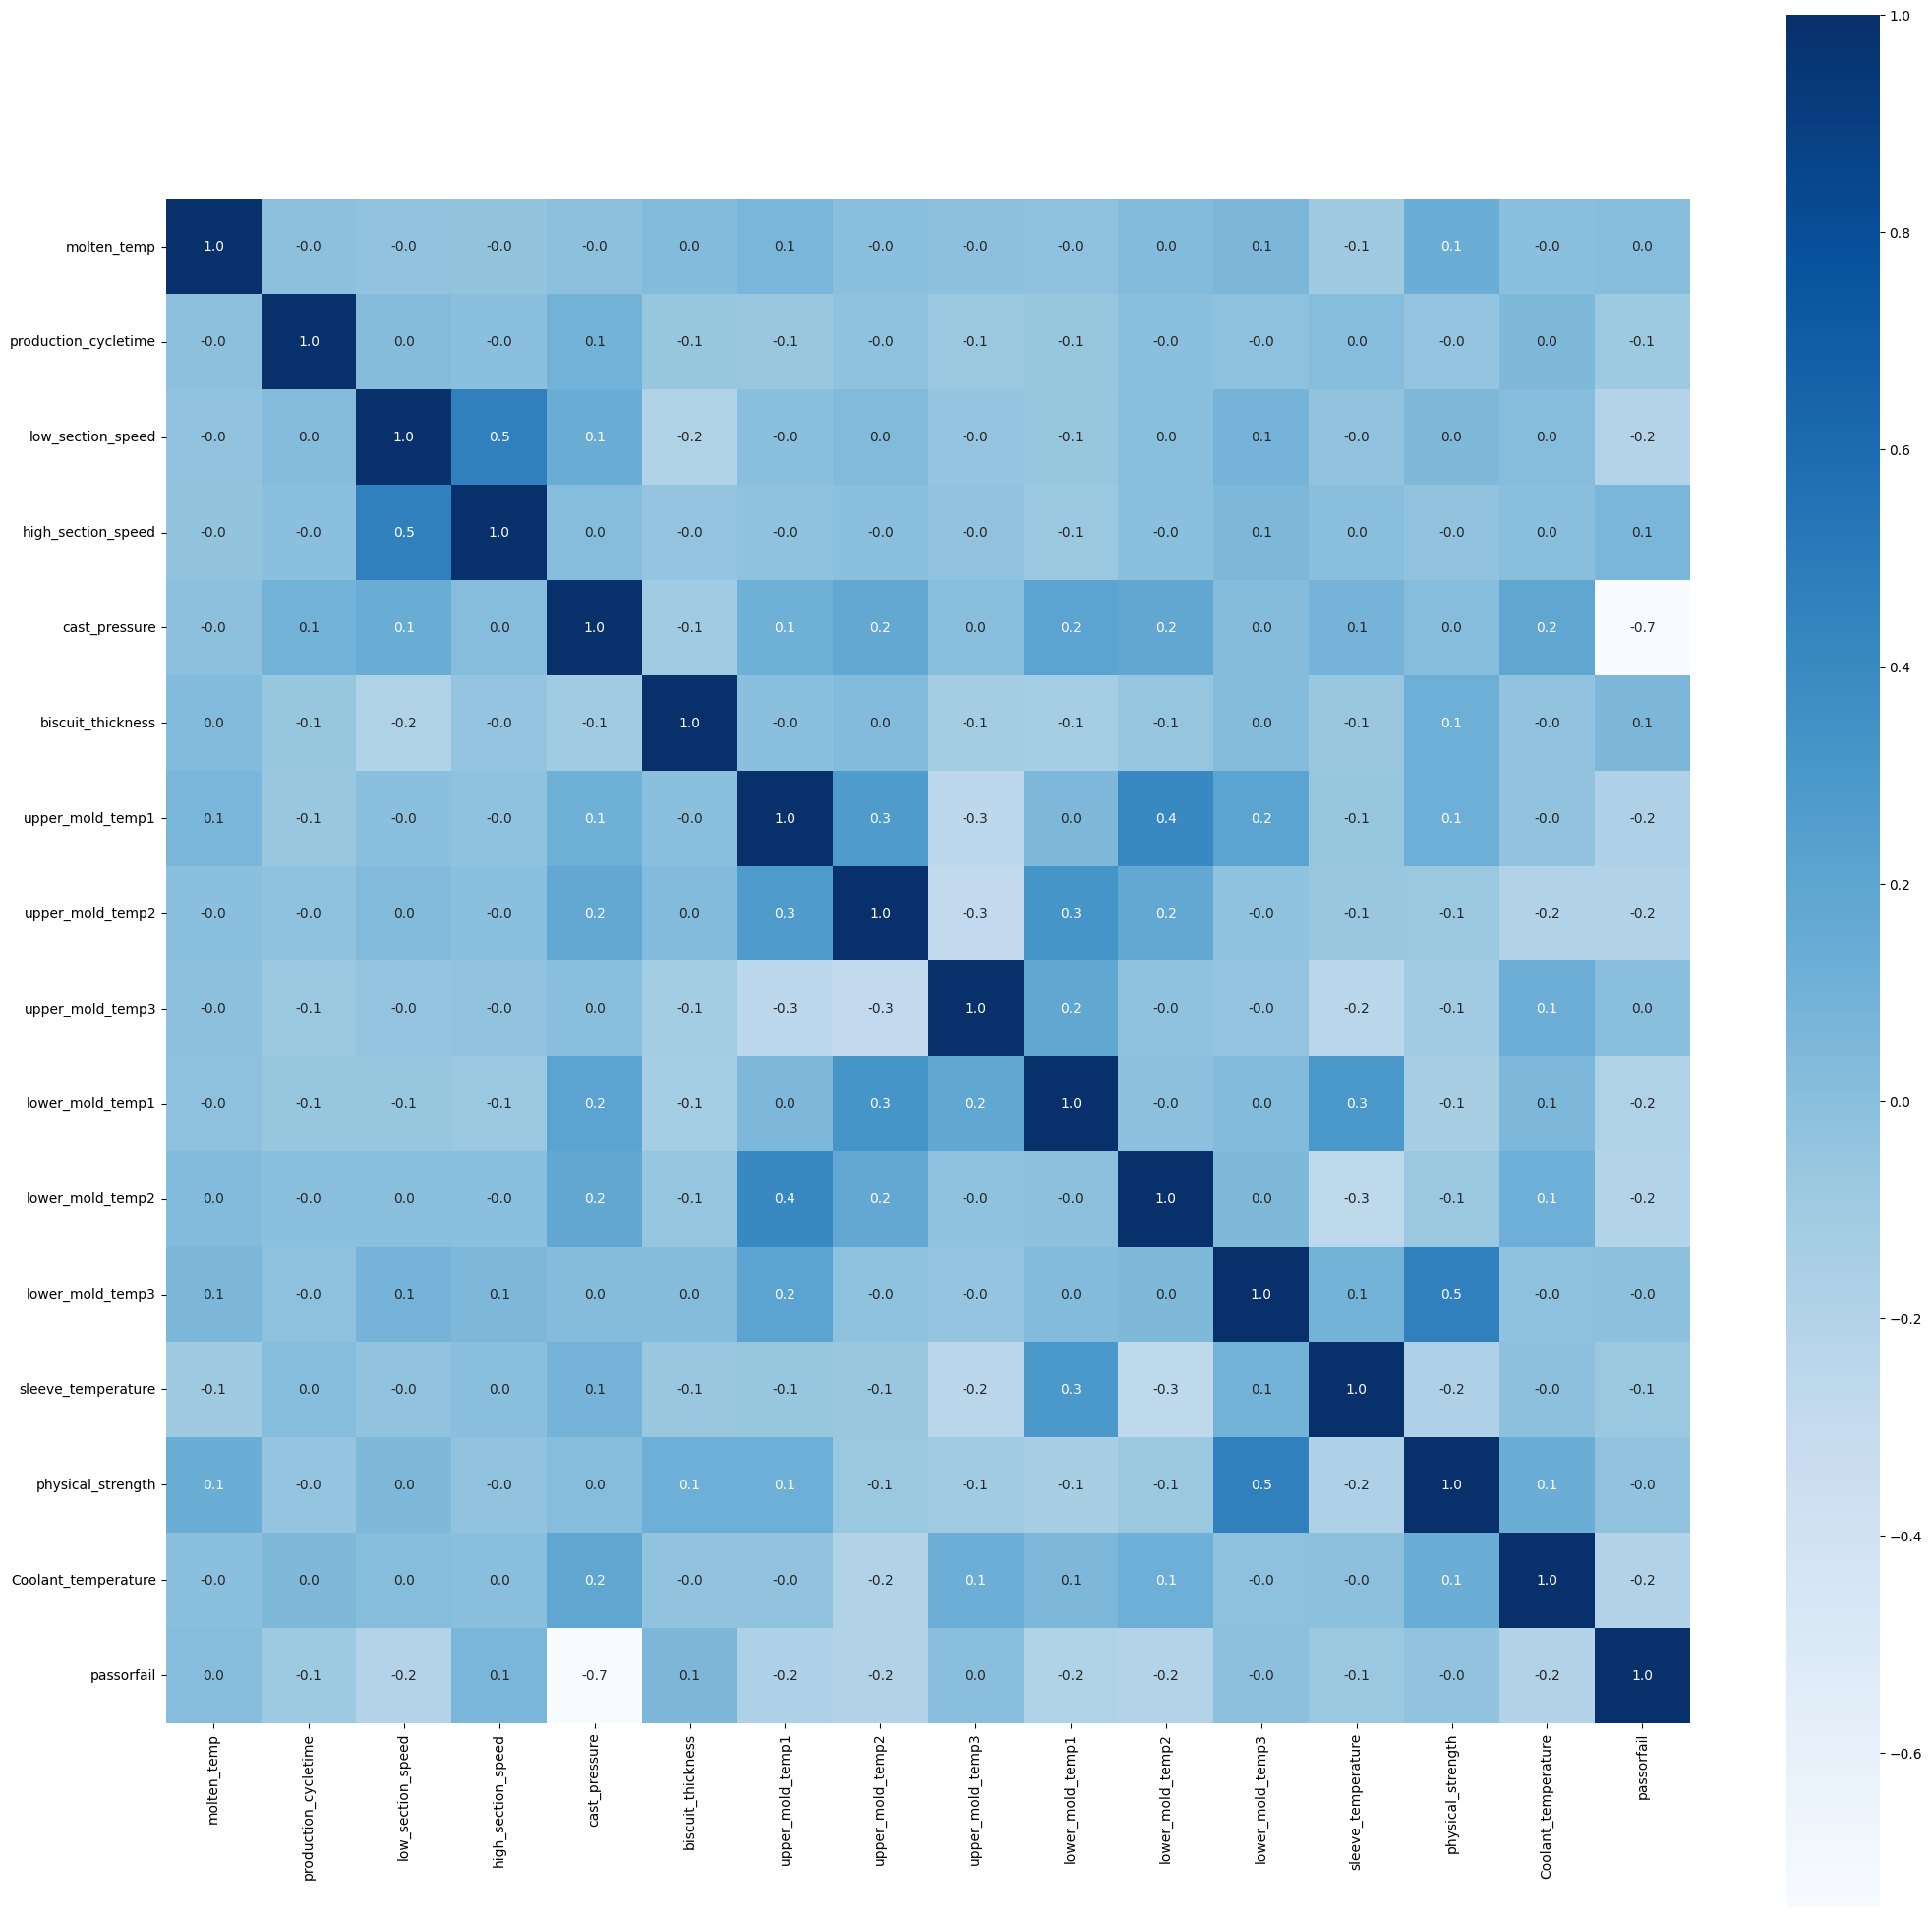

In [65]:
plt.figure(figsize=(25, 25))
sns.heatmap(df_copy.corr(), annot = True, fmt = '.1f', square = True, cmap = 'Blues')
plt.show()

In [66]:
X = df_copy.drop('passorfail', axis=1).values
y = df_copy['passorfail'].values

In [67]:
sss = StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2)

# 최종 데이터셋의 불량률이 3%에 불과할 정도로 데이터가 불균형적이기 때문에, 일반적인 train_test_split을 사용하면 데이터셋 구성이 불균형적으로 이뤄져 결과의 편차가 클 수 있다.
# 따라서 분할 split 마다 양품과 불량이 균등한 비율로 구성되도록 stratifiedShuffleSplit을 적용

In [68]:
mms = MinMaxScaler()

# 각 변수별로 값의 범위가 다르게 되면 모델은 크기가 큰 변수에 영향을 많이 받게 되어 부정확한 모델이 생성될 수 있음.


In [69]:
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42, eval_metric='error', use_label_encoder=False)
lgbm_clf = LGBMClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

In [70]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_fold_f1 = []
n_iter = 0
print('모델 :', dt_clf)
idx_list = []
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    for train_idx, valid_idx in sss.split(X_train, y_train):
        X_valid = X_train[valid_idx]
        y_valid = y_train[valid_idx]

    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)

    dt_clf.fit(X_train_scaled, y_train)
    valid_pred = dt_clf.predict(X_valid_scaled)
    test_pred = dt_clf.predict(X_test_scaled)

    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)

    n_iter += 1
    dt_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])

    print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
    print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
    print('='*50)

    dt_fold_f1.sort(key=lambda x : x[1], reverse=True)
    print(f'교차검증 중 가장 높은 정확도 : Split {dt_fold_f1[0][0]} {dt_fold_f1[0][1]}')

    # 일반적으로 사용하는 정확도(Accuracy)는 본 데이터셋과 같이 불량의 비율이 극히 적은 경우,
    # 데이터 셋에 대부분이 양품만 존재하여 정확도 측정시 99%가 나온다.
    # 따라서 정확도는 객관적인 지표가 될 수 없기 때문에, F1스코어를 지표로 사용한다

모델 : DecisionTreeClassifier(random_state=42)
StratifiedShuffleSplit 1 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 1 테스트 데이터 f1 정확도 : 0.8293487221764221
교차검증 중 가장 높은 정확도 : Split 1 0.8293487221764221
StratifiedShuffleSplit 2 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 2 테스트 데이터 f1 정확도 : 0.8344594594594594
교차검증 중 가장 높은 정확도 : Split 2 0.8344594594594594
StratifiedShuffleSplit 3 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 3 테스트 데이터 f1 정확도 : 0.8341625207296849
교차검증 중 가장 높은 정확도 : Split 2 0.8344594594594594
StratifiedShuffleSplit 4 검증 데이터 f1 정확도 : 0.9989550679205852
StratifiedShuffleSplit 4 테스트 데이터 f1 정확도 : 0.835421888053467
교차검증 중 가장 높은 정확도 : Split 4 0.835421888053467
StratifiedShuffleSplit 5 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 5 테스트 데이터 f1 정확도 : 0.8287841191066998
교차검증 중 가장 높은 정확도 : Split 4 0.835421888053467


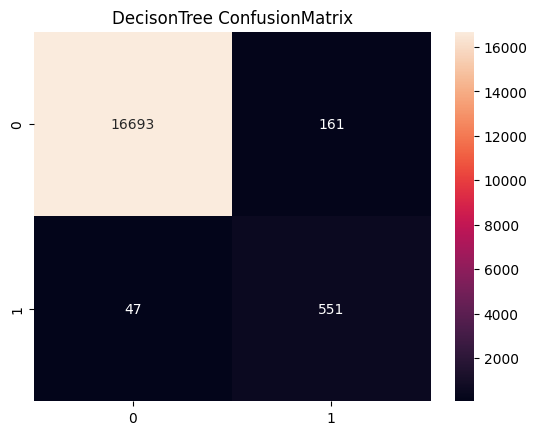

In [71]:
# decision tree 모델 confusionMatrix

dt_clf.fit(X[idx_list[dt_fold_f1[0][0]-1][0]], y[idx_list[dt_fold_f1[0][0]-1][0]])
pred = dt_clf.predict(X[idx_list[dt_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[dt_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.title('DecisonTree ConfusionMatrix')
plt.show()

#양품은 16,854개 중 161개를 불량으로 예측하고 불량은 598개 중 47개를 양품으로 예측했음을 확인

In [72]:
rf_clf = RandomForestClassifier(random_state=42)
rf_fold_f1 = []
n_iter = 0
print('모델 :', rf_clf)
idx_list = []


for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    for train_idx, valid_idx in sss.split(X_train, y_train):
        X_valid = X_train[valid_idx]
        y_valid = y_train[valid_idx]

    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)

    rf_clf.fit(X_train_scaled, y_train)
    valid_pred = rf_clf.predict(X_valid_scaled)
    test_pred = rf_clf.predict(X_test_scaled)

    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)

    n_iter += 1
    rf_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])

    print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
    print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
    print('='*50)
    dt_fold_f1.sort(key=lambda x : x[1], reverse=True)
    print(f'교차검증 중 가장 높은 정확도 : Split {rf_fold_f1[0][0]} {rf_fold_f1[0][1]}')

모델 : RandomForestClassifier(random_state=42)
StratifiedShuffleSplit 1 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 1 테스트 데이터 f1 정확도 : 0.8871111111111111
교차검증 중 가장 높은 정확도 : Split 1 0.8871111111111111
StratifiedShuffleSplit 2 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 2 테스트 데이터 f1 정확도 : 0.8701880035810206
교차검증 중 가장 높은 정확도 : Split 1 0.8871111111111111
StratifiedShuffleSplit 3 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 3 테스트 데이터 f1 정확도 : 0.857918552036199
교차검증 중 가장 높은 정확도 : Split 1 0.8871111111111111
StratifiedShuffleSplit 4 검증 데이터 f1 정확도 : 0.9989550679205852
StratifiedShuffleSplit 4 테스트 데이터 f1 정확도 : 0.872858431018936
교차검증 중 가장 높은 정확도 : Split 1 0.8871111111111111
StratifiedShuffleSplit 5 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 5 테스트 데이터 f1 정확도 : 0.8731884057971014
교차검증 중 가장 높은 정확도 : Split 1 0.8871111111111111


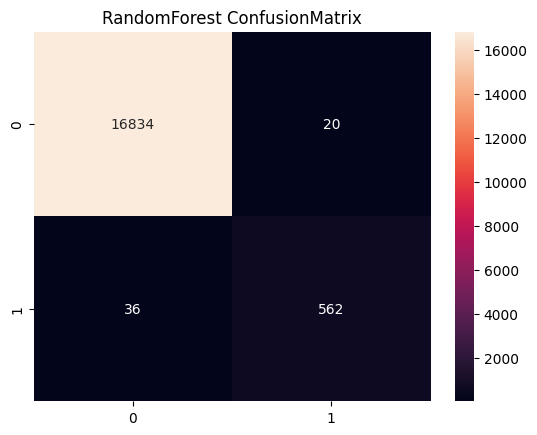

In [73]:
rf_clf.fit(X[idx_list[rf_fold_f1[0][0]-1][0]], y[idx_list[rf_fold_f1[0][0]-1][0]])
pred = rf_clf.predict(X[idx_list[rf_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[rf_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.title('RandomForest ConfusionMatrix')
plt.show()

# 가장 높은 정확도를 보인 split1 데이터셋으로 재학습 후 Confusion Matrix(혼동행렬) 확인
# 양품은 16,854개 중 20개를 불량으로 예측하고, 불량은 598개 중 36개를 양품으로 예측했음 확인



In [74]:
# XGBoost 모델 학습 및 결과

xgb_clf = XGBClassifier(random_state=42)
xgb_fold_f1 = []
n_iter = 0
print('모델 :', xgb_clf)
idx_list = []

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    for train_idx, valid_idx in sss.split(X_train, y_train):
        X_valid = X_train[valid_idx]
        y_valid = y_train[valid_idx]

    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)

    xgb_clf.fit(X_train_scaled, y_train)
    valid_pred = xgb_clf.predict(X_valid_scaled)
    test_pred = xgb_clf.predict(X_test_scaled)

    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)

    n_iter += 1
    xgb_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])

    print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
    print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
    print('='*50)
    xgb_fold_f1.sort(key=lambda x : x[1], reverse=True)
    print(f'교차검증 중 가장 높은 정확도 : Split {xgb_fold_f1[0][0]} {xgb_fold_f1[0][1]}')

모델 : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
StratifiedShuffleSplit 1 검증 데이터 f1 정확도 : 0.9655913978494624
StratifiedShuffleSplit 1 테스트 데이터 f1 정확도 : 0.9021645021645022
교차검증 중 가장 높은 정확도 : Split 1 0.9021645021645022
StratifiedShuffleSplit 2 검증 데이터 f1 정확도 : 0.9676724137931034
StratifiedSh

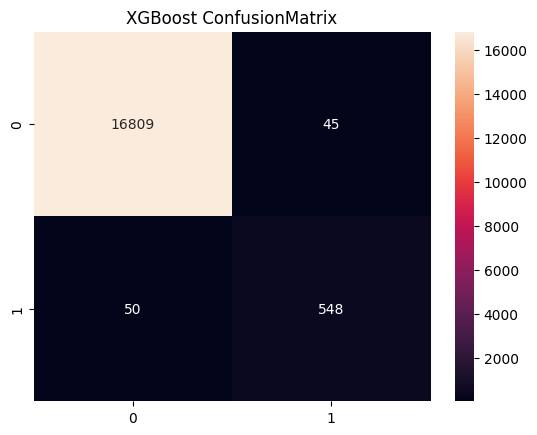

In [75]:
xgb_clf.fit(X[idx_list[xgb_fold_f1[0][0]-1][0]], y[idx_list[xgb_fold_f1[0][0]-1][0]])
pred = xgb_clf.predict(X[idx_list[xgb_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[xgb_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.title('XGBoost ConfusionMatrix')
plt.show()

# 가이드북과 다른 결과 나옴
# 양품 16,854개 중 45개를 불량으로 예측,
# 불량 598개 중 50개를 불량으로 예측

In [76]:
lgbm_clf = LGBMClassifier(random_state=42)
lgbm_fold_f1 = []
n_iter = 0
print('모델 :', lgbm_clf)
idx_list = []

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    for train_idx, valid_idx in sss.split(X_train, y_train):
        X_valid = X_train[valid_idx]
        y_valid = y_train[valid_idx]

    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)

    lgbm_clf.fit(X_train_scaled, y_train)
    valid_pred = lgbm_clf.predict(X_valid_scaled)
    test_pred = lgbm_clf.predict(X_test_scaled)

    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)

    n_iter += 1
    lgbm_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])

    print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
    print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
    print('='*50)
    lgbm_fold_f1.sort(key=lambda x : x[1], reverse=True)
    print(f'교차검증 중 가장 높은 정확도 : Split {lgbm_fold_f1[0][0]} {lgbm_fold_f1[0][1]}')

모델 : LGBMClassifier(random_state=42)
[LightGBM] [Info] Number of positive: 2394, number of negative: 67413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 69807, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034295 -> initscore=-3.337872
[LightGBM] [Info] Start training from score -3.337872
StratifiedShuffleSplit 1 검증 데이터 f1 정확도 : 0.9548387096774194
StratifiedShuffleSplit 1 테스트 데이터 f1 정확도 : 0.8952879581151832
교차검증 중 가장 높은 정확도 : Split 1 0.8952879581151832
[LightGBM] [Info] Number of positive: 2394, number of negative: 67413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if 

[LightGBM] [Info] Number of positive: 1941, number of negative: 53904
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 55845, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034757 -> initscore=-3.324001
[LightGBM] [Info] Start training from score -3.324001


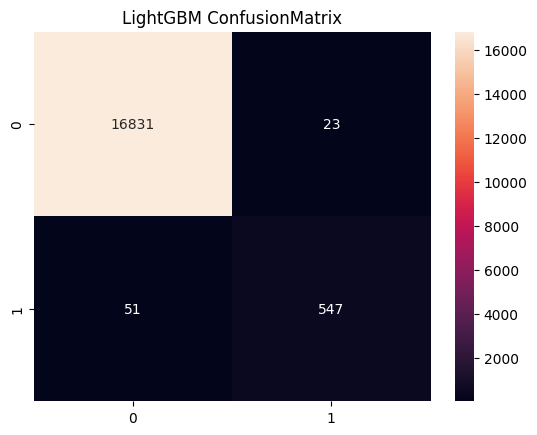

[[16831    23]
 [   51   547]]


In [77]:
lgbm_clf.fit(X[idx_list[lgbm_fold_f1[0][0]-1][0]], y[idx_list[lgbm_fold_f1[0][0]-1][0]])
pred = lgbm_clf.predict(X[idx_list[lgbm_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.title('LightGBM ConfusionMatrix')
plt.show()
print(cm)

In [78]:
# AdaBoost

ada_clf = AdaBoostClassifier(random_state=42)
ada_fold_f1 = []
n_iter = 0
print('모델 :', lgbm_clf)
idx_list = []

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    for train_idx, valid_idx in sss.split(X_train, y_train):
        X_valid = X_train[valid_idx]
        y_valid = y_train[valid_idx]

    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)

    ada_clf.fit(X_train_scaled, y_train)
    valid_pred = ada_clf.predict(X_valid_scaled)
    test_pred = ada_clf.predict(X_test_scaled)

    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)

    n_iter += 1
    ada_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])

    print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
    print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
    print('='*50)
    lgbm_fold_f1.sort(key=lambda x : x[1], reverse=True)
    print(f'교차검증 중 가장 높은 정확도 : Split {ada_fold_f1[0][0]} {ada_fold_f1[0][1]}')

모델 : LGBMClassifier(random_state=42)
StratifiedShuffleSplit 1 검증 데이터 f1 정확도 : 0.7575392038600723
StratifiedShuffleSplit 1 테스트 데이터 f1 정확도 : 0.8086710650329878
교차검증 중 가장 높은 정확도 : Split 1 0.8086710650329878
StratifiedShuffleSplit 2 검증 데이터 f1 정확도 : 0.7899761336515513
StratifiedShuffleSplit 2 테스트 데이터 f1 정확도 : 0.7928436911487758
교차검증 중 가장 높은 정확도 : Split 1 0.8086710650329878
StratifiedShuffleSplit 3 검증 데이터 f1 정확도 : 0.8182883939038686
StratifiedShuffleSplit 3 테스트 데이터 f1 정확도 : 0.7843511450381679
교차검증 중 가장 높은 정확도 : Split 1 0.8086710650329878
StratifiedShuffleSplit 4 검증 데이터 f1 정확도 : 0.8137603795966786
StratifiedShuffleSplit 4 테스트 데이터 f1 정확도 : 0.7786407766990291
교차검증 중 가장 높은 정확도 : Split 1 0.8086710650329878
StratifiedShuffleSplit 5 검증 데이터 f1 정확도 : 0.7927710843373494
StratifiedShuffleSplit 5 테스트 데이터 f1 정확도 : 0.7770334928229665
교차검증 중 가장 높은 정확도 : Split 1 0.8086710650329878


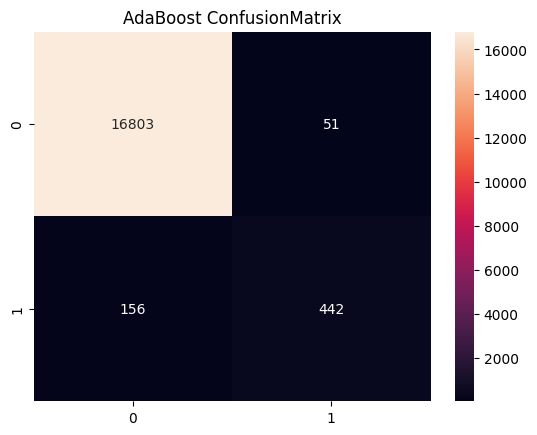

In [79]:
ada_clf.fit(X[idx_list[ada_fold_f1[0][0]-1][0]], y[idx_list[ada_fold_f1[0][0]-1][0]])
pred = ada_clf.predict(X[idx_list[ada_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[ada_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.title('AdaBoost ConfusionMatrix')
plt.show()

In [80]:
dt_test_f1_average = sum(item[1] for item in dt_fold_f1) / len(dt_fold_f1)
rf_test_f1_average = sum(item[1] for item in rf_fold_f1) / len(rf_fold_f1)
xgb_test_f1_average = sum(item[1] for item in xgb_fold_f1) / len(xgb_fold_f1)
lgbm_test_f1_average = sum(item[1] for item in lgbm_fold_f1) / len(lgbm_fold_f1)
ada_test_f1_average = sum(item[1] for item in ada_fold_f1) / len(ada_fold_f1)

print("decisionTree 평균 F1 값: ", dt_test_f1_average)
print("randomforest 평균 F1 값: ", rf_test_f1_average)
print("xgb 평균 F1 값: ", xgb_test_f1_average)
print("lgb 평균 F1 값: ", lgbm_test_f1_average)
print("ada 평균 F1 값: ", ada_test_f1_average)


decisionTree 평균 F1 값:  0.8324353419051466
randomforest 평균 F1 값:  0.8722529007088736
xgb 평균 F1 값:  0.8811435830138266
lgb 평균 F1 값:  0.8790338702142568
ada 평균 F1 값:  0.7883080341483855


In [81]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

# precision 계산
precision = precision_score(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)
# precision = (y_test, y_pred)

# Recall 계산
recall = recall_score(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)
# recall = (y_test, y_pred)

# F1 계산
f1 = 2 * (precision * recall) / (precision + recall)

# 오차행렬(?)
confusion = confusion_matrix(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)

# ROC-AUC
roc_auc = roc_auc_score(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)

print("Precision : ", precision)
print("Recall : ", recall)
print("F1 Score : ", f1)
print("오차 행렬 : ", confusion)
print("ROC AUC 값 : ", roc_auc)

Precision :  0.896551724137931
Recall :  0.7391304347826086
F1 Score :  0.8102658111824015
오차 행렬 :  [[16803    51]
 [  156   442]]
ROC AUC 값 :  0.8680522234432801


<Axes: >

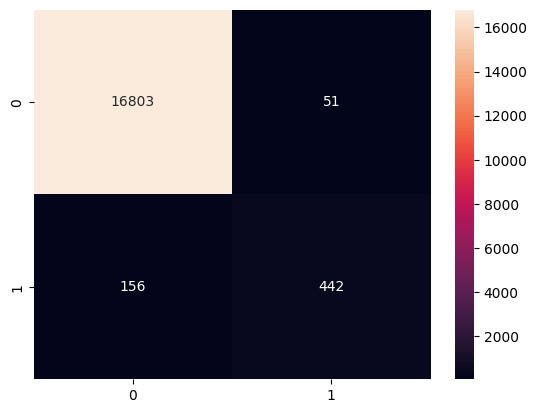

In [82]:
# cm = confusion_matrix(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)
sns.heatmap(confusion, annot=True, fmt='.0f')

In [83]:
pred_proba_class1 = lgbm_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [   1    6   11   16   21   26   31   36   41   46   51   56   61   66
   71   76   81   86   91   96  101  106  111  116  121  126  131  136
  141  146  151  156  161  166  171  176  181  186  191  196  201  206
  211  216  221  226  231  236  241  246  251  256  261  266  271  276
  281  286  291  296  301  306  311  316  321  326  331  336  341  346
  351  356  361  366  371  376  381  386  391  396  401  406  411  416
  421  426  431  436  441  446  451  456  461  466  471  476  481  486
  491  496  501  506  511  516  521  526  531  536  541  546  551  556
  561  566  571  576  581  586  591  596  601  606  611  616  621  626
  631  636  641  646  651  656  661  666  671  676  681  686  691  696
  701  706  711  716  721  726  731  736  741  746  751  756  761  766
  771  776  781  786  791  796  801  806  811  816  821  826  831  836
  841  846  851  856  861  866  871  876  881  886  891  896  901  906
  911  916  921  926  931  936  941  946  951  956  

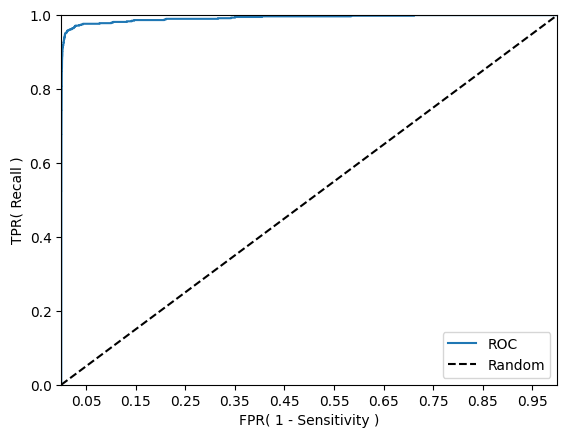

In [84]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음.
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림.
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

roc_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:,1])

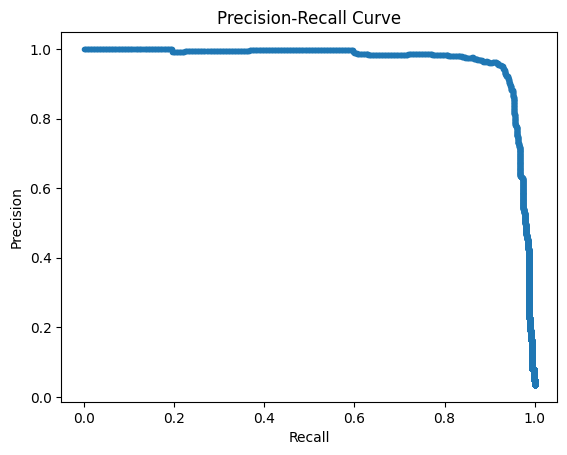

In [85]:
# 테스트 데이터에 대한 예측 확률을 얻습니다.
y_probs = lgbm_clf.predict_proba(X[idx_list[lgbm_fold_f1[0][0]-1][1]])[:, 1]

# Precision-Recall 곡선을 계산합니다.
precision, recall, _ = precision_recall_curve(y[idx_list[lgbm_fold_f1[0][0]-1][1]], y_probs)

# Precision-Recall 곡선을 그립니다.
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [86]:
from sklearn.model_selection import StratifiedKFold
import optuna
import optuna.integration.lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

def objective(trial, X, y):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),  ## 숫자범위 줄이기
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),   # 숫자범위 줄이기 
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),  
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbosity': -1
    }
    
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, valid_idx in kf.split(X, y):
        X_train = X[train_idx]
        X_valid = X[valid_idx]
        y_train = y[train_idx]
        y_valid = y[valid_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        
        model = lgb.train(param, train_data, valid_sets=[valid_data])
        preds = model.predict(X_valid)
        score = f1_score(y_valid, preds.round())
        scores.append(score)

    return np.mean(scores)

# 데이터 준비
X = df_copy.drop('passorfail', axis=1).values
y = df_copy['passorfail'].values

# 옵투나 최적화 실행
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=0), pruner=SuccessiveHalvingPruner())  # maximize로 변경,
##!!
###! Sample 코드 추가!!
###!!
study.optimize(lambda trial: objective(trial, X, y), n_trials=50)   # n_trials 숫자 낮추기

# 결과 출력
print('Best trial:')
best_trial = study.best_trial
print(f'  Value: {best_trial.value}')
print('  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-03-25 23:06:31,304] A new study created in memory with name: no-name-48aeaba4-e62e-475b-83c8-3b2831b4e14a
[I 2024-03-25 23:06:31,316] A new study created in memory with name: no-name-c73e34dd-39cd-4141-9a6f-d3dc95197e98
min_child_samples, val_score: 0.024869: 100%|##########| 5/5 [00:10<00:00,  2.16s/it]
[I 2024-03-25 23:11:21,066] A new study created in memory with name: no-name-69e31daf-f820-4700-9b38-da8036558c7d
min_child_samples, val_score: 0.022861: 100%|##########| 5/5 [00:09<00:00,  1.99s/it]
[I 2024-03-25 23:16:06,109] A new study created in memory with name: no-name-a8c9ca93-2791-4252-be5d-e96a78b9ec86
min_child_samples, val_score: 0.024909: 100%|##########| 5/5 [00:09<00:00,  1.99s/it]
[I 2024-03-25 23:20:59,361] Trial 0 finished with value: 0.8780078768018523 and parameters: {'num_leaves': 141, 'learning_rate': 0.1346941509642705, 'feature_fraction': 0.6424870384644795, 'bagging_fraction': 0.5903948646972071, 'bagging_freq': 5}. Best is trial 0 with value: 0.8780078

Best trial:
  Value: 0.8845367168993739
  Params: 
    num_leaves: 67
    learning_rate: 0.008342345486268596
    feature_fraction: 0.3904695067222417
    bagging_fraction: 0.8515335446723125
    bagging_freq: 6
